Liegt der Peak der durch den Reflektor hervorgerufen wird immer komplett im Bandpass?

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

folder = '/home/dgotzens/recording/'

loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...
loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...


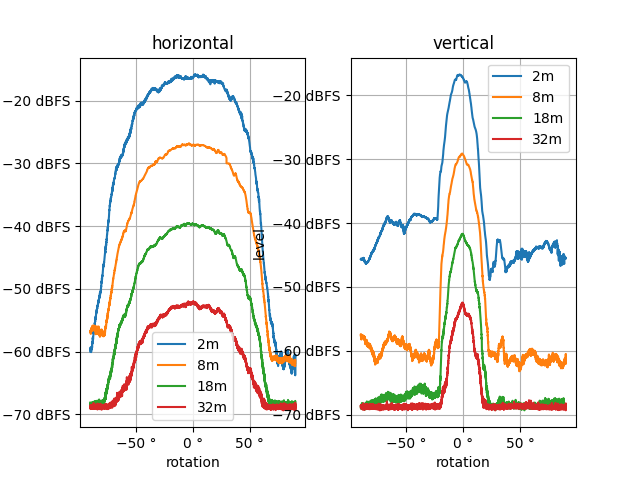

In [2]:
%matplotlib widget
fig,ax = plt.subplots(1,2)

for m, measurement in enumerate(('a','d')):
    for n, dist in enumerate((2,8,18,32)):
        with open(f'{folder}{measurement}{dist:02d}_angle.pkl', 'rb') as f:
            angle = pickle.load(f)
        l_deg = [l for l,a in enumerate(angle) if -90 < a*180/pi-90 < 90]
        angle_deg = [a*180/pi - 90 for l,a in enumerate(angle) if l in l_deg]
        data = torch.load(f'{folder}{measurement}{dist:02d}_data.pt')[:,:,l_deg]
        M,K,L = data.shape

        print(f'loaded data for {dist}m. processing...')

        bp_start = int((dist-0.5)*bins_per_meter)
        bp_len = int(1*bins_per_meter)

        window = torch.hann_window(M)
        window = window / window.sum()

        gain = torch.empty(L)

        fft = torch.fft.fft(window[:,None,None]*data, n=nfft, dim=0)
        m_refl = fft[bp_start:bp_start+bp_len,:,:].abs().mean(1).argmax(0) + bp_start
        gain = fft.abs().mean(1)[m_refl, range(L)]
        ax[m].plot(angle_deg, 20*gain.log10(), label=f'{dist}m')
    ax[m].yaxis.set_major_formatter(EngFormatter('dBFS'))
    ax[m].set_ylabel('level')
    ax[m].set_xlabel('rotation')
    ax[m].xaxis.set_major_formatter(EngFormatter('°'))
    ax[m].grid()
    ax[m].legend()
    ax[m].set_title('horizontal' if m==0 else 'vertical')


loaded data for 2m. processing...
torch.Size([181, 192])
loaded data for 8m. processing...
torch.Size([181, 192])
loaded data for 18m. processing...
torch.Size([180, 192])
loaded data for 32m. processing...
torch.Size([181, 192])
loaded data for 2m. processing...
torch.Size([181, 192])
loaded data for 8m. processing...
torch.Size([181, 192])
loaded data for 18m. processing...
torch.Size([180, 192])
loaded data for 32m. processing...
torch.Size([180, 192])


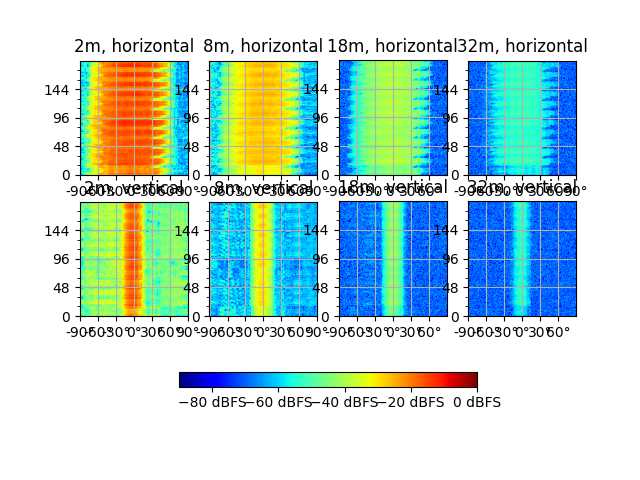

In [12]:
%matplotlib widget
fig,ax = plt.subplots(2,4)

for m, measurement in enumerate(('a','d')):
    for n, dist in enumerate((2,8,18,32)):
        with open(f'{folder}{measurement}{dist:02d}_angle.pkl', 'rb') as f:
            angle = pickle.load(f)
        angle_deg = [round(a*180/pi-90) for a in angle]
        l_deg = [angle_deg.index(a) for a in sorted(set(angle_deg))]
        angle_deg = list(sorted(set(angle_deg)))
        data = torch.load(f'{folder}{measurement}{dist:02d}_data.pt')[:,:,l_deg]
        M,K,L = data.shape

        print(f'loaded data for {dist}m. processing...')

        bp_start = int((dist-0.5)*bins_per_meter)
        bp_len = int(1*bins_per_meter)

        window = torch.hann_window(M)
        window = window / window.sum()

        gain = torch.empty(L)

        fft = torch.fft.fft(window[:,None,None]*data, n=nfft, dim=0)
        m_refl = fft[bp_start:bp_start+bp_len,:,:].abs().mean(1).argmax(0) + bp_start
        gain = fft.abs()[m_refl, :, range(L)]
        print(gain.shape)
        im = ax[m,n].imshow(20*gain.T.log10(), origin='lower', vmin=-90, vmax=0, cmap='jet')
        ax[m,n].set_yticks(range(0,192,16*3), minor=False)
        ax[m,n].set_yticks(range(0,192,16), minor=True)
        ax[m,n].set_xticks(range(0,L,L//6), [f'{round(angle_deg[l],-1)}°' for l in range(0,L,L//6)])
        ax[m,n].grid()
        ax[m,n].set_title(f'{dist}m, ' + ('horizontal','vertical')[m])

fig.colorbar(im,ax=ax.ravel(), orientation='horizontal', format=EngFormatter('dBFS'), shrink=0.6)

loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...


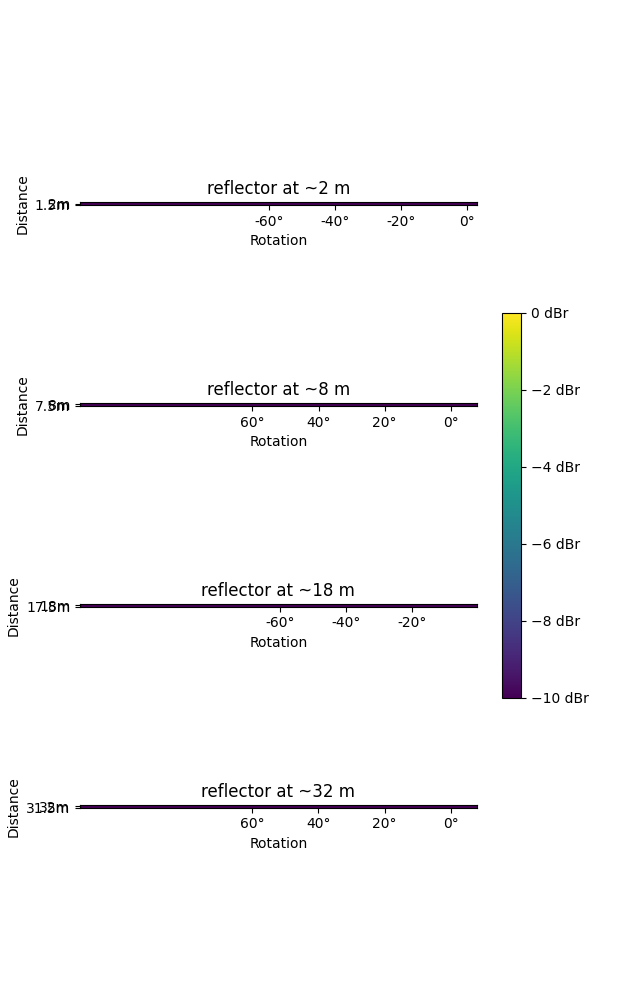

In [3]:
fig,ax = plt.subplots(4)
fig.set_figheight(10)
difs = lambda x, vals : [abs(v-x) for v in vals]
closest_index = lambda x, vals : difs(x,vals).index(min(difs(x,vals)))

for n, dist in enumerate((2,8,18,32)):
    with open(f'{folder}d{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)
    angle_deg = [a*180/pi - 90 for a in angle]
    l_deg = [l for l,a in enumerate(angle_deg) if -60<a<60]
    data = torch.load(f'{folder}d{dist:02d}_data.pt')[:,:,l_deg]
    M,K,L = data.shape

    print(f'loaded data for {dist}m. processing...')

    bp = torch.zeros(nfft)
    bp_start = int((dist-0.5)*bins_per_meter)
    bp_len = int(1*bins_per_meter)
    bp[bp_start:bp_start+bp_len] = torch.ones(bp_len)
    bp = bp.unsqueeze(-1)

    window = torch.hann_window(M).unsqueeze(-1)
    window = window / window.sum()
    img = torch.zeros((bp_len,L))

    yvals = [dist-0.5, dist, dist+0.5]
    ax[n].set_yticks([v*bins_per_meter - bp_start for v in yvals], [f'{v}m' for v in yvals])

    xvals = range(-60,60+1,20)
    ax[n].set_xticks([closest_index(v, angle_deg) for v in xvals], [f'{v}°' for v in xvals])

    ax[n].set_title(f'reflector at ~{dist} m')
    ax[n].set_xlabel('Rotation')
    ax[n].set_ylabel('Distance')
    for k in range(K):
        img += torch.fft.fft(window*data[:,k,:], dim=0, n=nfft)[bp_start:bp_start+bp_len,:].abs()/K
    # plot data
    im = ax[n].imshow(20*img.log10() - 20*img.log10().max(), origin='lower', vmin=-10, vmax=0)
fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, format=EngFormatter('dBr'))

In [4]:
folder = '/home/dgotzens/shares/messdaten/000_Products/iMCR/2024-01-29_Antenna_Gain_3m_LD_dgs/processed/'
for part in range(20):
    print(f'loading part {part}')
    fft = torch.load(folder+f'schwenks_{part:02d}_bp_fft.pt')
    angle = pickle.load(open(folder+f'schwenks_{part:02d}_angle.pt','rb'))
    angle = [a*180/pi-90 for a in angle]
    M,K,L = fft.shape
    m_refl = fft.flatten(1).abs().argmax(0)
    amplitude = fft.flatten(1)[m_refl,range(K*L)].unflatten(1,(K,L)).abs().mean(1)
    plt.plot(angle, 20*amplitude.log10())
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter('dB'))
plt.show()


loading part 0


FileNotFoundError: [Errno 2] No such file or directory: '/home/dgotzens/shares/messdaten/000_Products/iMCR/2024-01-29_Antenna_Gain_3m_LD_dgs/processed/schwenks_00_angle.pt'